In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.6.0


## Hyperparameters

In [ ]:
seq_len = 128

## Load Microsoft price and volume data

In [ ]:
MSFT_path = '/content/drive/My Drive/Transformer_Stock/MSFT_data.csv'

df = pd.read_csv(MSFT_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,47894400


## Plot daily Microsoft closing prices

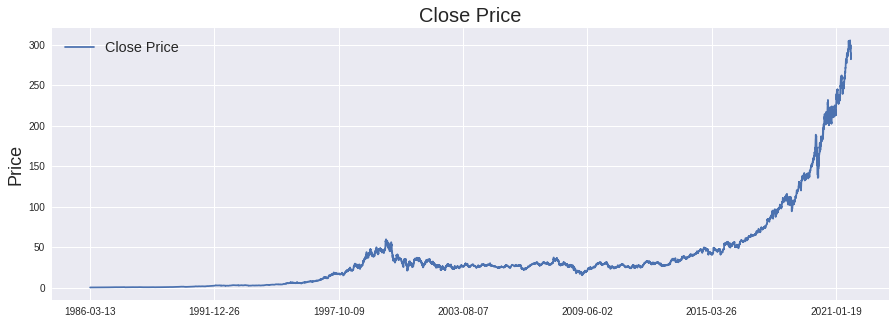

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Plot daily Microsoft volumes

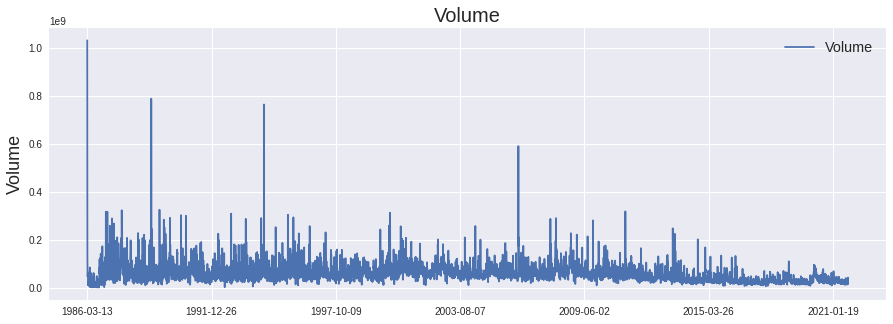

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Calculate normalized percentage change for all columns

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (7170, 5)
Validation data shape: (896, 5)
Test data shape: (896, 5)


,Open,High,Low,Close,Volume
1,0.787018,0.610593,0.787018,0.664151,0.015262
2,0.664151,0.610450,0.664151,0.627753,0.023856
3,0.627753,0.593744,0.559754,0.543604,0.028795
4,0.543604,0.544025,0.559157,0.559458,0.041535
5,0.559458,0.542759,0.540938,0.541405,0.074584


## Plot daily changes of close prices and volume

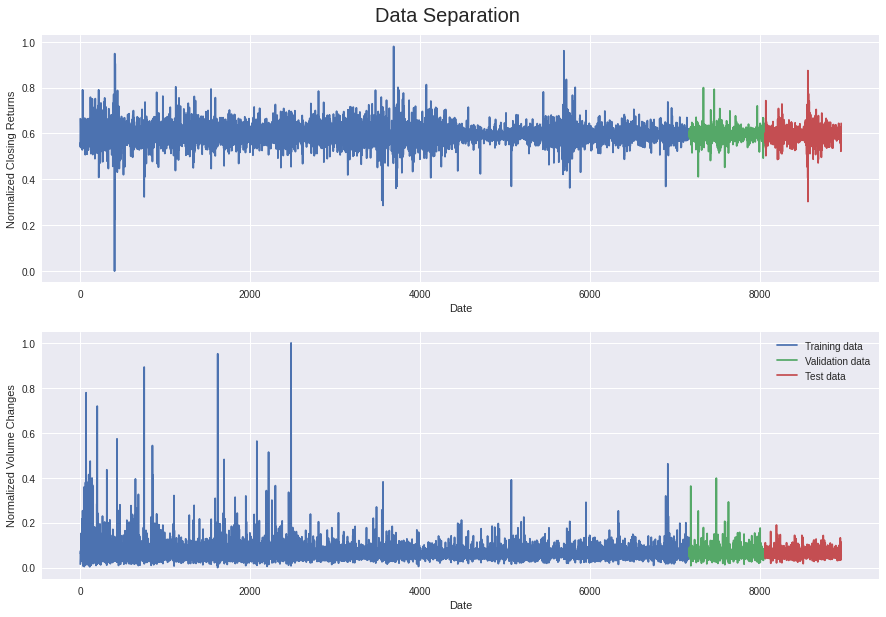

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Create chunks of training, validation and test data

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7042, 128, 5) (7042,)
(768, 128, 5) (768,)


## 1D Convolution layers for a CNN+LSTM model

In [ ]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)
  
  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)  
  
  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3) 
  
  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)  
  
  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)  
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)  
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)    
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)   
  
  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)
  
  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)   
  
  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)   
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)  
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)  
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)   

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl) 
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)  
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)  
  
  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)  
  
  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

# **Testing different model architectures**

### Bi-LSTM model

In [ ]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    


Epoch 1/200
4/4 - 20s - loss: 0.0898 - mae: 0.2470 - mape: 19076.3281 - val_loss: 0.0040 - val_mae: 0.0577 - val_mape: 9.5245

Epoch 00001: val_loss improved from inf to 0.00397, saving model to Bi-LSTM.hdf5
Epoch 2/200
4/4 - 4s - loss: 0.0098 - mae: 0.0863 - mape: 98516.3594 - val_loss: 0.0121 - val_mae: 0.1064 - val_mape: 17.6910

Epoch 00002: val_loss did not improve from 0.00397
Epoch 3/200
4/4 - 5s - loss: 0.0076 - mae: 0.0733 - mape: 70376.0312 - val_loss: 0.0051 - val_mae: 0.0673 - val_mape: 11.4792

Epoch 00003: val_loss did not improve from 0.00397
Epoch 4/200
4/4 - 4s - loss: 0.0046 - mae: 0.0550 - mape: 85779.4141 - val_loss: 0.0020 - val_mae: 0.0376 - val_mape: 6.1805

Epoch 00004: val_loss improved from 0.00397 to 0.00198, saving model to Bi-LSTM.hdf5
Epoch 5/200
4/4 - 4s - loss: 0.0034 - mae: 0.0461 - mape: 92833.3906 - val_loss: 9.2830e-04 - val_mae: 0.0224 - val_mape: 3.8226

Epoch 00005: val_loss improved from 0.00198 to 0.00093, saving model to Bi-LSTM.hdf5
Epoch 6/20

 
Evaluation metrics
Training Data - Loss: 0.0010, MAE: 0.0217, MAPE: 3.7600
Validation Data - Loss: 0.0003, MAE: 0.0131, MAPE: 2.1428
Test Data - Loss: 0.0006, MAE: 0.0178, MAPE: 2.9333


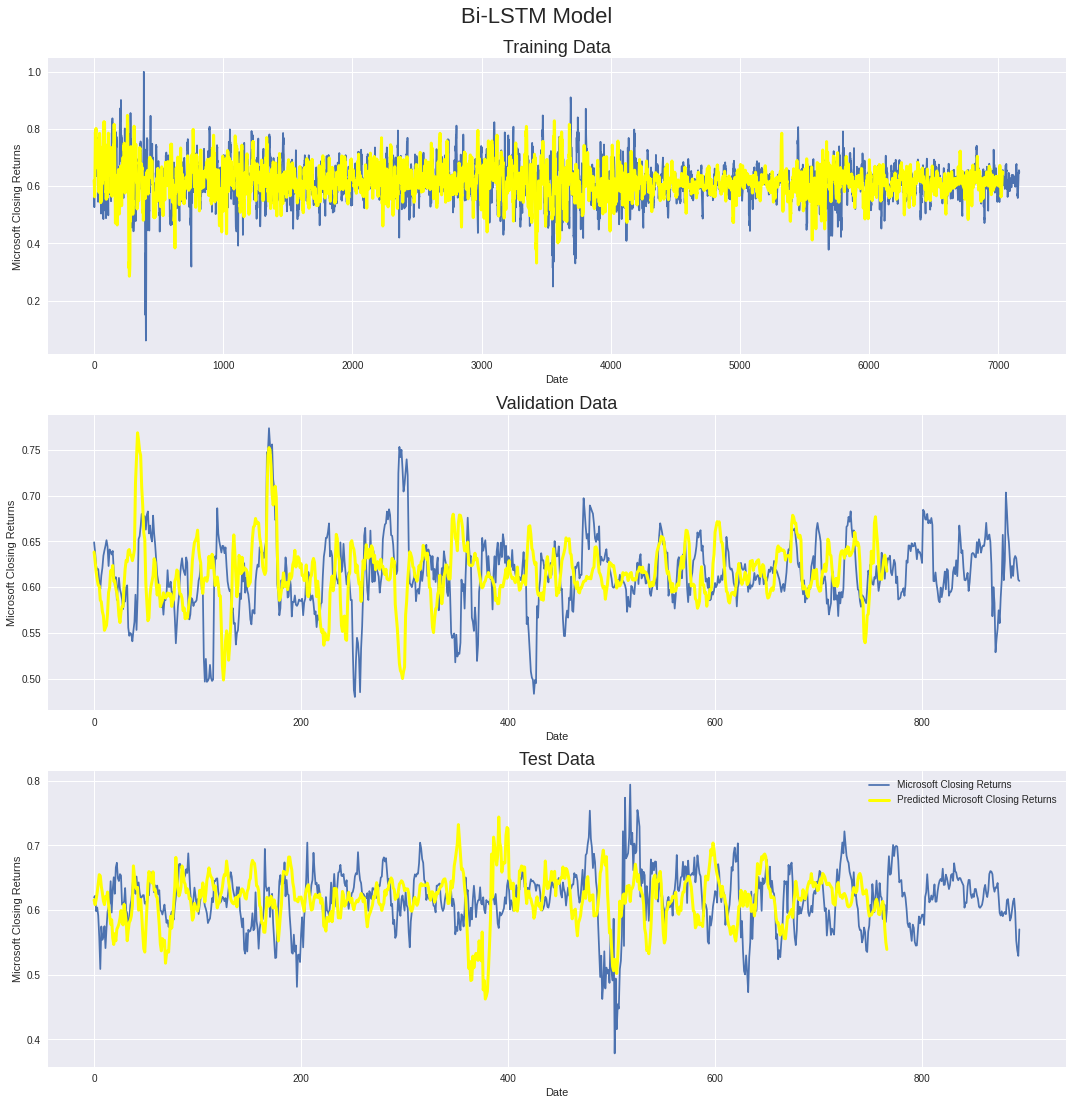

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Microsoft Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted Microsoft Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Microsoft Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Microsoft Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted Microsoft Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Microsoft Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Microsoft Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted Microsoft Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Microsoft Closing Returns')

plt.tight_layout()
plt.legend(loc='best')

### CNN + Bi-LSTM model

Epoch 1/200
4/4 - 57s - loss: 0.0091 - mae: 0.0813 - mape: 73113.5781 - val_loss: 0.0085 - val_mae: 0.0880 - val_mape: 14.5951

Epoch 00001: val_loss improved from inf to 0.00846, saving model to CNN+Bi-LSTM.hdf5
Epoch 2/200
4/4 - 4s - loss: 0.0028 - mae: 0.0411 - mape: 88351.0703 - val_loss: 0.0067 - val_mae: 0.0774 - val_mape: 12.8160

Epoch 00002: val_loss improved from 0.00846 to 0.00669, saving model to CNN+Bi-LSTM.hdf5
Epoch 3/200
4/4 - 4s - loss: 0.0024 - mae: 0.0360 - mape: 81003.7266 - val_loss: 0.0061 - val_mae: 0.0734 - val_mape: 12.1486

Epoch 00003: val_loss improved from 0.00669 to 0.00608, saving model to CNN+Bi-LSTM.hdf5
Epoch 4/200
4/4 - 4s - loss: 0.0021 - mae: 0.0335 - mape: 86345.4688 - val_loss: 0.0050 - val_mae: 0.0660 - val_mape: 10.9121

Epoch 00004: val_loss improved from 0.00608 to 0.00503, saving model to CNN+Bi-LSTM.hdf5
Epoch 5/200
4/4 - 4s - loss: 0.0020 - mae: 0.0315 - mape: 85375.6484 - val_loss: 0.0052 - val_mae: 0.0675 - val_mape: 11.1612

Epoch 00005:

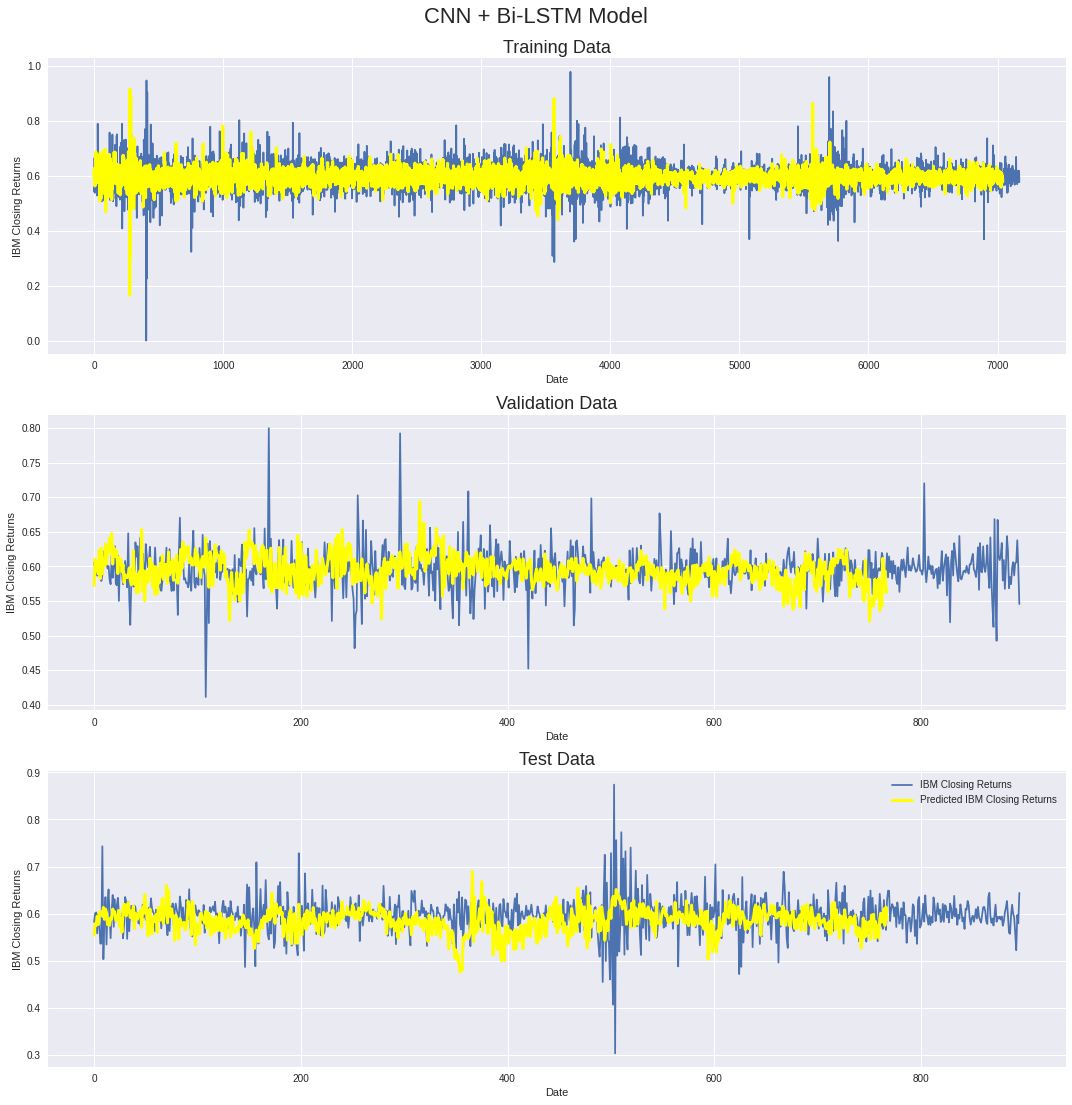

In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/CNN+Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Microsoft Closing Returns')
ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted Microsoft Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Microsoft Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Microsoft Closing Returns')
ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted Microsoft Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Microsoft Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Microsoft Closing Returns')
ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted Microsoft Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Microsoft Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

# **Moving Average Analysis**

## Loading Microsoft data again to apply a moving average effect

In [ ]:
MSFT_path = '/content/drive/MyDrive/Transformer_Stock/MSFT_data.csv'

df = pd.read_csv(MSFT_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 

df.head()

,Date,Open,High,Low,Close,Volume
9,1986-03-26,0.095746,0.098698,0.093837,0.096354,182733120.0
10,1986-03-27,0.096354,0.098177,0.094444,0.096267,81239040.0
11,1986-03-31,0.096267,0.097569,0.094097,0.095746,51710400.0
12,1986-04-01,0.095746,0.096788,0.093490,0.094965,39502080.0
13,1986-04-02,0.094965,0.096180,0.093056,0.094531,35426880.0


## Moving Average - Plot daily Microsoft closing prices

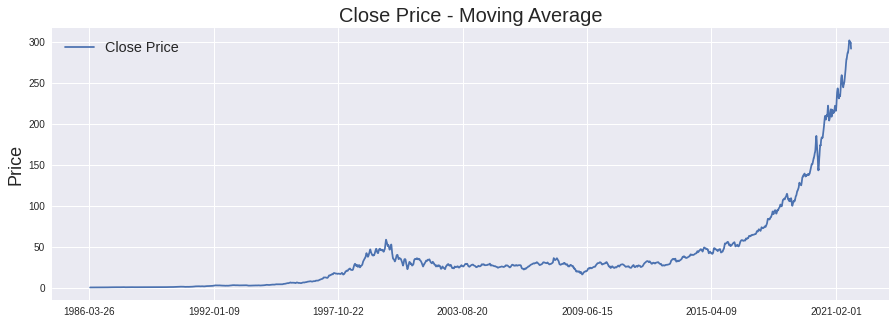

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Price', fontsize=18)
plt.title("Close Price - Moving Average", fontsize=20)
plt.legend(['Close Price'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Plot daily Microsoft volumes

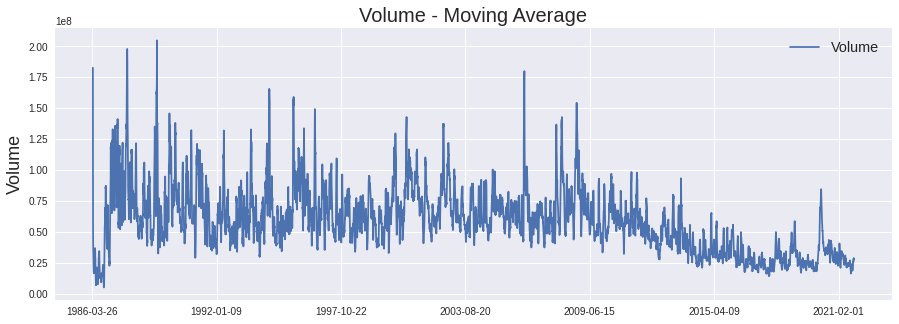

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['Volume'])
plt.xticks(range(0, df.shape[0], 1464), df['Date'].loc[::1464], rotation=0)
plt.ylabel('Volume', fontsize=18)
plt.title("Volume - Moving Average", fontsize=20)
plt.legend(['Volume'], fontsize='x-large', loc='best')
plt.show()

## Moving Average - Calculate normalized percentage change for all columns

In [ ]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (7163, 5)
Validation data shape: (895, 5)
Test data shape: (895, 5)


,Open,High,Low,Close,Volume
10,0.667679,0.554554,0.668936,0.597151,0.000000
11,0.597151,0.545677,0.570140,0.553267,0.113673
12,0.553267,0.527986,0.543076,0.526502,0.189115
13,0.526502,0.544813,0.560739,0.561441,0.267837
14,0.570336,0.588352,0.596840,0.588046,0.287385


## Moving Average - Plot daily changes of close prices and volume

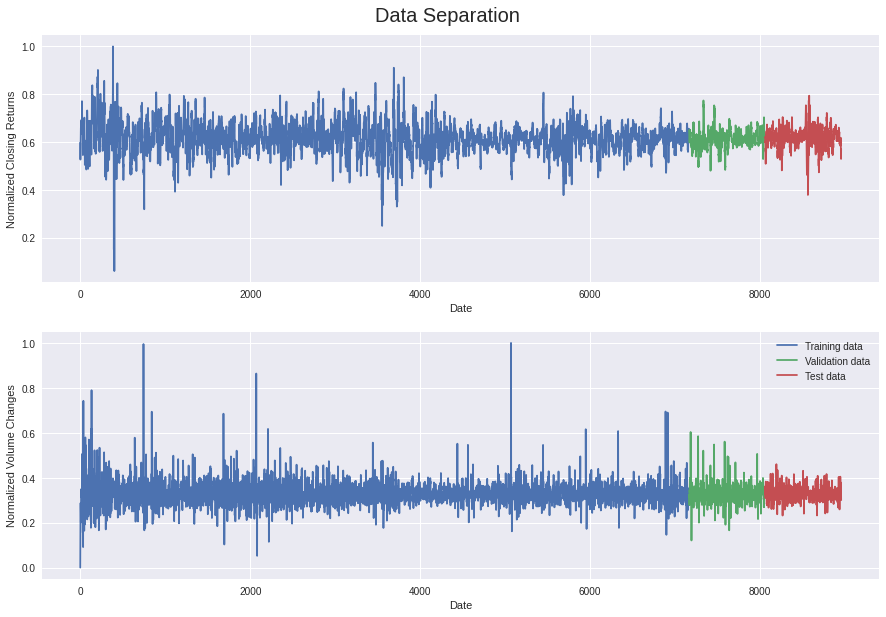

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Moving Average - Create chunks of training, validation and test data

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7035, 128, 5) (7035,)
(767, 128, 5) (767,)


# **Moving Average - Testing different model architectures**

### Moving Average - Bi-LSTM model

In [ ]:
def create_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

Epoch 1/200
4/4 - 15s - loss: 0.0064 - mae: 0.0619 - mape: 10.5780 - val_loss: 0.0014 - val_mae: 0.0270 - val_mape: 4.4119

Epoch 00001: val_loss improved from inf to 0.00144, saving model to Bi-LSTM.hdf5
Epoch 2/200
4/4 - 4s - loss: 0.0045 - mae: 0.0494 - mape: 8.7345 - val_loss: 0.0016 - val_mae: 0.0290 - val_mape: 4.6368

Epoch 00002: val_loss did not improve from 0.00144
Epoch 3/200
4/4 - 4s - loss: 0.0044 - mae: 0.0482 - mape: 8.5277 - val_loss: 0.0017 - val_mae: 0.0294 - val_mape: 4.6993

Epoch 00003: val_loss did not improve from 0.00144
Epoch 4/200
4/4 - 4s - loss: 0.0043 - mae: 0.0478 - mape: 8.3125 - val_loss: 0.0014 - val_mae: 0.0275 - val_mape: 4.5177

Epoch 00004: val_loss did not improve from 0.00144
Epoch 5/200
4/4 - 4s - loss: 0.0043 - mae: 0.0476 - mape: 8.2737 - val_loss: 0.0016 - val_mae: 0.0299 - val_mape: 4.9825

Epoch 00005: val_loss did not improve from 0.00144
Epoch 6/200
4/4 - 4s - loss: 0.0042 - mae: 0.0476 - mape: 8.4526 - val_loss: 0.0017 - val_mae: 0.0300 -

 
Evaluation metrics
Training Data - Loss: 0.0010, MAE: 0.0224, MAPE: 3.9009
Validation Data - Loss: 0.0004, MAE: 0.0136, MAPE: 2.2168
Test Data - Loss: 0.0006, MAE: 0.0180, MAPE: 2.9718


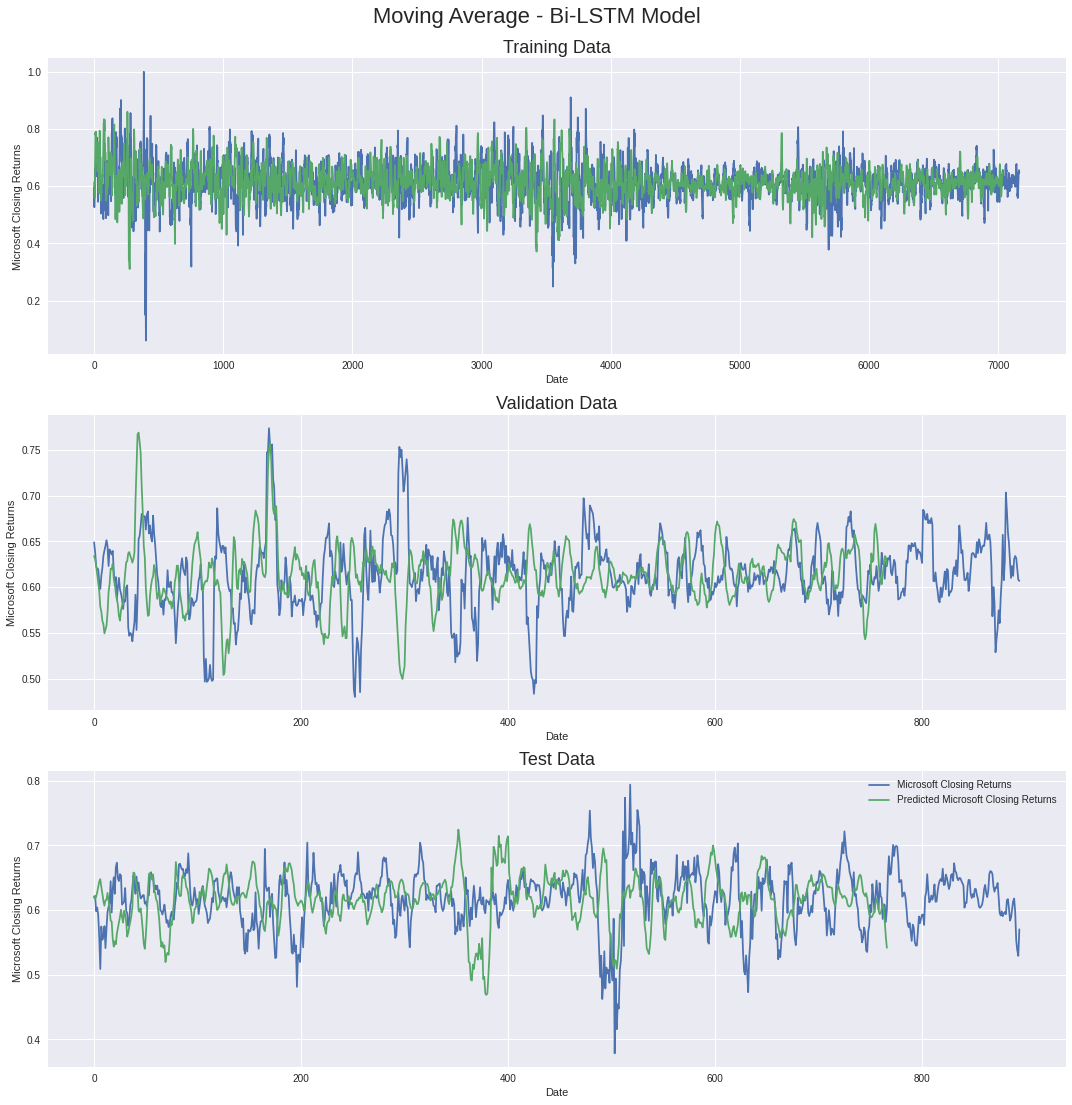

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Microsoft Closing Returns')
ax11.plot(train_pred, label='Predicted Microsoft Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Microsoft Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Microsoft Closing Returns')
ax21.plot(val_pred, label='Predicted Microsoft Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Microsoft Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Microsoft Closing Returns')
ax31.plot(test_pred, label='Predicted Microsoft Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Microsoft Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')

### Moving Average - CNN + Bi-LSTM model

Epoch 1/200
4/4 - 30s - loss: 0.0097 - mae: 0.0793 - mape: 13.4511 - val_loss: 0.0116 - val_mae: 0.1012 - val_mape: 16.1439

Epoch 00001: val_loss improved from inf to 0.01159, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 2/200
4/4 - 4s - loss: 0.0049 - mae: 0.0530 - mape: 9.4219 - val_loss: 0.0102 - val_mae: 0.0943 - val_mape: 15.0274

Epoch 00002: val_loss improved from 0.01159 to 0.01021, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 3/200
4/4 - 4s - loss: 0.0043 - mae: 0.0488 - mape: 8.3300 - val_loss: 0.0093 - val_mae: 0.0894 - val_mape: 14.2217

Epoch 00003: val_loss improved from 0.01021 to 0.00927, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 4/200
4/4 - 4s - loss: 0.0041 - mae: 0.0466 - mape: 8.3519 - val_loss: 0.0089 - val_mae: 0.0876 - val_mape: 13.9397

Epoch 00004: val_loss improved from 0.00927 to 0.00895, saving model to MA-CNN+Bi-LSTM.hdf5
Epoch 5/200
4/4 - 4s - loss: 0.0038 - mae: 0.0452 - mape: 7.8624 - val_loss: 0.0084 - val_mae: 0.0846 - val_mape: 13.4596

Epoch 00005: val_lo

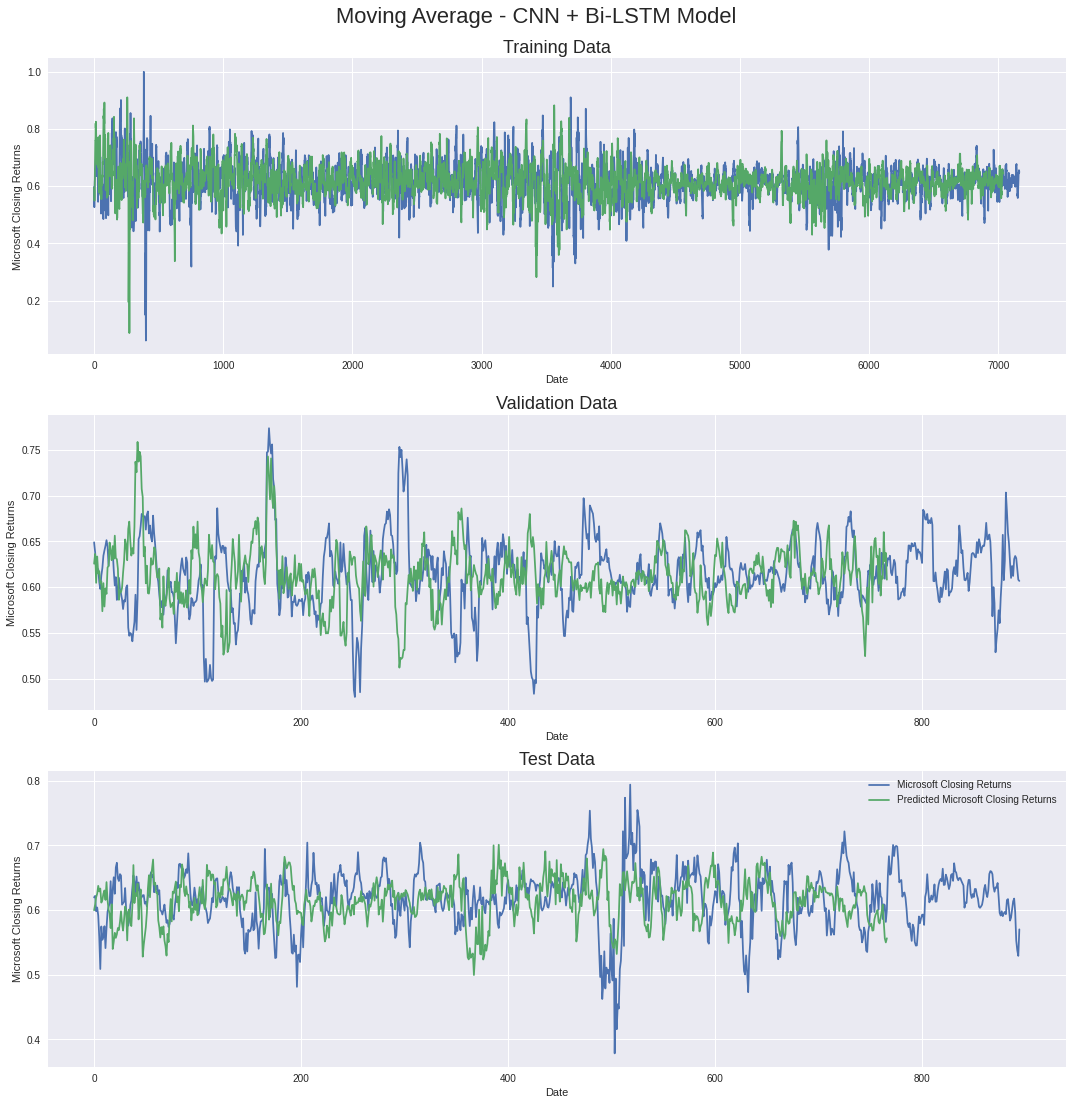

In [ ]:
def create_model():
  in_seq = Input(shape=(seq_len, 5))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)    
          
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])     
  return model

model = create_model()

#model.summary()
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
callback = tf.keras.callbacks.ModelCheckpoint('MA-CNN+Bi-LSTM.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X_train, y_train,
              batch_size=2048,
              verbose=2,
              callbacks=[callback],
              epochs=200,
              #shuffle=True,
              validation_data=(X_val, y_val),)    

model = tf.keras.models.load_model('/content/drive/MyDrive/Transformer_Stock/MA-CNN+Bi-LSTM.hdf5')

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,15))
st = fig.suptitle("Moving Average - CNN + Bi-LSTM Model", fontsize=22)
st.set_y(1.02)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Microsoft Closing Returns')
ax11.plot(train_pred, label='Predicted Microsoft Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Microsoft Closing Returns')

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Microsoft Closing Returns')
ax21.plot(val_pred, label='Predicted Microsoft Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Microsoft Closing Returns')

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Microsoft Closing Returns')
ax31.plot(test_pred, label='Predicted Microsoft Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Microsoft Closing Returns')
 
plt.tight_layout()
plt.legend(loc='best')


---
Sequential NN Results
---
##### **Bi-LSTM**
> Validation Data - Loss: 0.0003, MAE: 0.0131, MAPE: 2.1428

> Test Data - Loss: 0.0006, MAE: 0.0178, MAPE: 2.9333

##### **CNN+Bi-LSTM**
> Validation Data - Loss: 0.0012, MAE: 0.0248, MAPE: 4.1523

> Test Data - Loss: 0.0022, MAE: 0.0343, MAPE: 5.8016

---
Sequential NN + Moving Average Integrated Results
---

##### **Moving Average Bi-LSTM**
> Validation Data - Loss: 0.0004, MAE: 0.0136, MAPE: 2.2168

> Test Data - Loss: 0.0006, MAE: 0.0180, MAPE: 2.9718

##### **Moving Average CNN+Bi-LSTM**

> Validation Data - Loss: 0.0005, MAE: 0.0172, MAPE: 2.8074

> Test Data - Loss: 0.0009, MAE: 0.0213, MAPE: 3.5096

